# Кластеризация текстовой коллекции и визуализация.

### Подгрузим необходимые библиотеки

In [1]:
import time
import nltk
import pickle
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.manifold import TSNE

### Получим данные

In [2]:
categories = [
        'comp.graphics',
        'sci.space',
        'rec.autos',
        'sci.electronics',
        'rec.sport.hockey',
    ]
NUM_CLUSTERS = 5

def save_data_locally():
    start_time = time.time()
    data_train = fetch_20newsgroups(subset='train', categories=categories,
                                     shuffle=True, random_state=42)
    data_test = fetch_20newsgroups(subset='test', categories=categories,
                                     shuffle=True, random_state=42)
    print(time.time() - start_time)
    with open('20news_dataset_train.pickle', 'wb') as file:
        pickle.dump(data_train, file)
    with open('20news_dataset_test.pickle', 'wb') as file:
        pickle.dump(data_test, file)
    print(time.time() - start_time)

def get_data(test=False):
    with open('20news_dataset_train.pickle', 'rb') as file:
            data_train = pickle.load(file)
    if not test:
        return data_train
    with open('20news_dataset_test.pickle', 'rb') as file:
        data_test = pickle.load(file)
    return data_train, data_test

## Перейдём к написанию вспомогательных функций

### Функции препроцессинга текста

In [3]:
def preprocess_simple(line):
    line = line.lower()
    for punct in string.punctuation:
        line = line.replace(punct, '')
    return line

def preprocess_stemming(line):
    line = preprocess_simple(line)
    stemmer = nltk.stem.porter.PorterStemmer()
#     stemmer = nltk.stem.snowball.EnglishStemmer()
    text = line.split(' ')
    stems = []
    for word in text:
        stems.append(stemmer.stem(word))
    line = ' '.join(stems)
    return line

def preprocess_lemmatization(line):
    line = preprocess_simple(line)
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    text = line.split(' ')
    lemmas = []
    for word in text:
        lemmas.append(lemmatizer.lemmatize(word))
    line = ' '.join(lemmas)
    return line

### Функция векторизации, поддерживаются BagOfWords и TFIDF подходы, возвращает разреженную матрицу признаков и список лейблов признаков

In [16]:
def vectorize_data(vec_type, data, max_features=False, return_feature_names=False, stemming=False, lemmatization=False):
    if vec_type == 'tf':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(data.data)
    elif vec_type == 'tfidf':
        if stemming:
            stop = stop_words_stemmed
            preprocessor = preprocess_stemming
        elif lemmatization:
            preprocessor = preprocess_lemmatization
            stop = stop_words_lemmatized
        else:
            preprocessor = preprocess_simple
            vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_features=max_features if max_features else 1000,
                                         preprocessor=preprocessor)
            X = vectorizer.fit_transform(data.data)
            if return_feature_names:
                return X, vectorizer.get_feature_names()
            return X
#             stop = stop_words
        vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop, max_features=max_features if max_features else 1000,
                                     preprocessor=preprocessor)
        X = vectorizer.fit_transform(data.data)
        if return_feature_names:
            return X, vectorizer.get_feature_names()
        return X        

### Функция кластеризации, поддерживает выбор алгоритма кластеризации передачей аргументов 'kmeans', 'dbscan', 'agglomerative', 'lda', 'gmm'. Возвращает обученную модель. Число кластеров определяется с помощью GridSearch

In [46]:
def cluster_data(clustering_type, X, grid_search=False, labels=False, cv=None):
    if grid_search:
        if clustering_type == 'dbscan':
            print('Invalid algorithm choice for using GridSearchCV. Try another one.')
            return
        parameters_1 = {'n_clusters': [4, NUM_CLUSTERS]}
        parameters_2 = {'n_components': [NUM_CLUSTERS, 10]}
        algorithms = {'kmeans': KMeans(init='k-means++'), 'agglomerative': AgglomerativeClustering(),
                      'lda': LatentDirichletAllocation(), 'gmm': GaussianMixture()}
        algo = algorithms[clustering_type]
        if clustering_type == 'kmeans' or clustering_type == 'agglomerative':
            parameters = parameters_1
        else:
            parameters = parameters_2
        grid_search_cv_clustering = GridSearchCV(algo, parameters, cv=cv)
#         if cv:
#             grid_search_cv_clustering = GridSearchCV(algo, parameters, cv=cv)
#         else:
#             grid_search_cv_clustering = GridSearchCV(algo, parameters, cv=None)
        grid_search_cv_clustering.fit(X)
        print(grid_search_cv_clustering.best_params_)
        model = grid_search_cv_clustering.best_estimator_.fit(X)
    elif clustering_type == 'kmeans':
        model = KMeans(n_clusters=NUM_CLUSTERS, init='k-means++').fit(X)
    elif clustering_type == 'dbscan':
        model = DBSCAN().fit(X)
    elif clustering_type == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(X)
    elif clustering_type == 'lda':
        model = LatentDirichletAllocation(n_components=NUM_CLUSTERS, max_iter=5, learning_method='online', 
                                          learning_offset=50., random_state=0).fit(X)
    elif clustering_type == 'gmm':
        model = GaussianMixture(n_components=NUM_CLUSTERS, covariance_type='full').fit(X)
    return model

### Функция для вывода "топовых" фичей для каждой категории текстов

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

### Функции для визуализации данных

In [7]:
def visualize_simple(X_embedded, labels, ax=None):
    palette = sns.color_palette("bright", n_colors=NUM_CLUSTERS)
    if ax is None:
        sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette=palette)
    else:
        sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=labels, legend='full', palette=palette, ax=ax)
        
def visualize(X_embedded, max_features=1000, experiment=False, labels=None):
    if not experiment:
        labels = labels_global
        visualize_simple(X_embedded, labels)
    else:
        nrows = len(labels) // 2 if len(labels) % 2 == 0 else len(labels) // 2 + 1
        ncols = 2
        f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(12, 4 * nrows))
        for i in range(len(labels)):
            row = i // 2
            col = 0 if i % 2 == 0 else 1
            visualize_simple(X_embedded, labels=labels[i], ax=axes[i] if nrows == 1 else axes[row, col])

### Функция для проведения эксперимента (без и с GridSearchCV)

In [47]:
def process_experiment(X, max_features=1000, grid_search=False, cv=None):
    labels = labels_global
    start_time = time.time()
    kmeans = cluster_data('kmeans', X, grid_search=True if grid_search else False, cv=cv)
#     print(labels)
#     print(kmeans.labels_)
    print(adjusted_rand_score(labels, kmeans.labels_))
    print(f'Clustering using KMeans has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    dbscan = cluster_data('dbscan', X, cv=cv)
#     print(labels)
#     print(dbscan.labels_)
    print(adjusted_rand_score(labels, dbscan.labels_))
    print(f'Clustering using DBSCAN has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    agglomerative = cluster_data('agglomerative', X.todense(), grid_search=False if grid_search else False, cv=cv)
    print(adjusted_rand_score(labels, agglomerative.labels_))
    print(f'Clustering using AgglomerativeClustering has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    lda = cluster_data('lda', X, grid_search=True if grid_search else False, cv=cv)
    print(f'Clustering using LatentDirichletAllocation has been processed for {time.time() - start_time} seconds.')

    start_time = time.time()
    gmm = cluster_data('gmm', X.todense(), grid_search=True if grid_search else False, cv=cv)
#     print(labels)
#     print(gmm.predict(X.todense()))
    print(adjusted_rand_score(labels, gmm.predict(X.todense())))
    print(f'Clustering using Gaussian Mixture Model has been processed for {time.time() - start_time} seconds.')
#     print_top_words(lda, feature_names, 20)
#     print(categories)

    return kmeans, dbscan, agglomerative, lda, gmm

In [9]:
def get_lda_labels(lda, n_features):
    lda_labels = []
    for i in range(n_features):
        tmp = np.array([lda.components_[j][i] for j in range(NUM_CLUSTERS)])
        lda_labels.append(np.argmax(tmp))
    return lda_labels

In [10]:
def get_gmm_labels(gmm, X):
    return gmm.predict(X.todense())

In [11]:
def get_dbscan_labels(dbscan):
    dbscan_labels = np.array([0 for label in dbscan.labels_])
    dbscan_labels[0] = 1
    dbscan_labels[1] = 2
    dbscan_labels[2] = 3
    dbscan_labels[3] = 4
    return dbscan_labels

## Перейдём непосредственно к экспериментальной части

#### Во-первых, о сравнении BagOfWords и TFIDF: здесь вполне очевидны и преимущества, и недостатки обоих подходов. Более того, они взаимно вытекают друг из друга. BagOfWords быстро строится, однако больший вес отдаётся часто встречающимся в документе словам, никак не анализируется частота встречаемости слова на уровне коллекции. Таким образом, в нем большой вес могут получить просто общеупотребимые слова (даже с учетом отбрасывания стоп-слов), что однако никак не помогает нам "корректно" сравнивать полученные векторы между собой. TFIDF, напротив, строится дольше (это надстройка над подсчётом tf в BagOfWords), учитывается обратная документная частота термина, то есть редкость(для исследователя - важность) термина на уровне коллекции. Безусловно, в TFIDF больший вес получают действительно "полезные" для дальнейшего анализа фичи. Разница в скорости вычислений не настолько велика, чтобы отказаться от TFIDF. Мой выбор всегда в его пользу.

### Подгрузим данные и проведём векторизацию - подготовим объекты для проведения экспериментов

In [29]:
start_time = time.time()

nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words_stemmed = set()
stop_words_lemmatized = set()
for stop_word in stop_words:
    stop_words_stemmed.add(preprocess_stemming(stop_word))
    stop_words_lemmatized.add(preprocess_lemmatization(stop_word))
stop_words_stemmed.add('becau')

data_train, data_test = get_data(test=True)
labels_global = data_train.target

X_500, feature_names = vectorize_data('tfidf', data_train, max_features=500, return_feature_names=True)
X_1000 = vectorize_data('tfidf', data_train, max_features=1000)
X_2000 = vectorize_data('tfidf', data_train, max_features=2000)
X_5000 = vectorize_data('tfidf', data_train, max_features=5000)
X_10000 = vectorize_data('tfidf', data_train, max_features=10000)
tsne_500 = TSNE(n_components=2)
tsne_1000 = TSNE(n_components=2)
tsne_2000 = TSNE(n_components=2)
tsne_5000 = TSNE(n_components=2)
tsne_10000 = TSNE(n_components=2)
X_embedded_500 = tsne_500.fit_transform(X_500)
X_embedded_1000 = tsne_1000.fit_transform(X_1000)
X_embedded_2000 = tsne_2000.fit_transform(X_2000)
X_embedded_5000 = tsne_5000.fit_transform(X_5000)
X_embedded_10000 = tsne_10000.fit_transform(X_10000)

print(f'Processed for {time.time() - start_time} seconds.')

Processed for 100.69226717948914 seconds.


### Визуализируем исходные данные

#### Max_features=500:

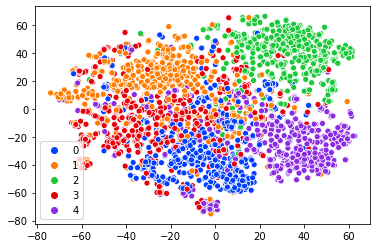

In [18]:
visualize(X_embedded=X_embedded_500, max_features=500)

#### Max_features=1000:

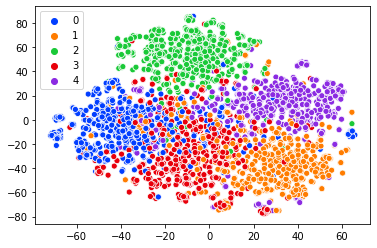

In [19]:
visualize(X_embedded=X_embedded_1000, max_features=1000)

#### Max_features=2000:

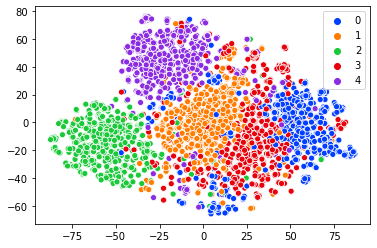

In [20]:
visualize(X_embedded=X_embedded_2000, max_features=2000)

#### Max_features=5000:

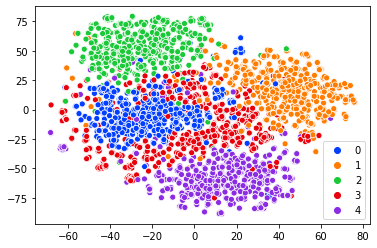

In [21]:
visualize(X_embedded=X_embedded_5000, max_features=5000)

##### Видим довольно много пересечений между категориями, готовимся морально к невысокому качеству из-за сильного пересечения категорий 0 и 3. Ох и непросто будет алгоритмам кластеризации.

### Кластеризация БЕЗ GridSearchCV, max_features=500.

In [22]:
kmeans, dbscan, agglomerative, lda, gmm = process_experiment(X_500, max_features=500)

0.349852105573981
Clustering using KMeans has been processed for 22.28674077987671 seconds.
-1.2438492866269665e-05
Clustering using DBSCAN has been processed for 0.43039917945861816 seconds.
0.20376263963624994
Clustering using AgglomerativeClustering has been processed for 1.9808406829833984 seconds.
Clustering using LatentDirichletAllocation has been processed for 2.9313085079193115 seconds.
0.35786660990019126
Clustering using Gaussian Mixture Model has been processed for 2.575160503387451 seconds.


### Визуализация

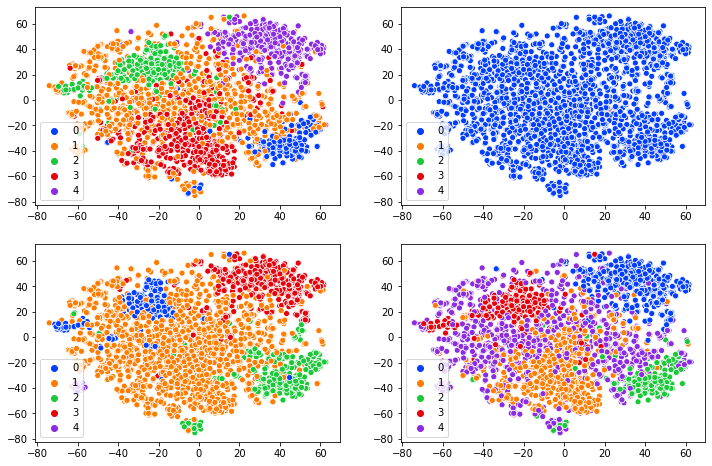

In [23]:
dbscan_labels = get_dbscan_labels(dbscan)
gmm_labels = get_gmm_labels(gmm, X_500)
lda_labels = get_lda_labels(lda, 500)
visualize(X_embedded=X_embedded_500, max_features=500, experiment=True, labels=[kmeans.labels_, dbscan_labels, agglomerative.labels_, gmm_labels])

##### Совсем неудовлетворительный результат, что однако было вполне ожидаемо при использовании словаря размером всего 500 фичей.

### Кластеризация БЕЗ GridSearchCV, max_features=1000.

In [24]:
kmeans, dbscan, agglomerative, lda, gmm = process_experiment(X_1000, max_features=1000)

0.46022655547379765
Clustering using KMeans has been processed for 31.424102544784546 seconds.
0.0
Clustering using DBSCAN has been processed for 0.48246026039123535 seconds.
0.2925498007838687
Clustering using AgglomerativeClustering has been processed for 3.784135580062866 seconds.
Clustering using LatentDirichletAllocation has been processed for 2.0929832458496094 seconds.
0.488364585470003
Clustering using Gaussian Mixture Model has been processed for 4.614493370056152 seconds.


### Визуализация

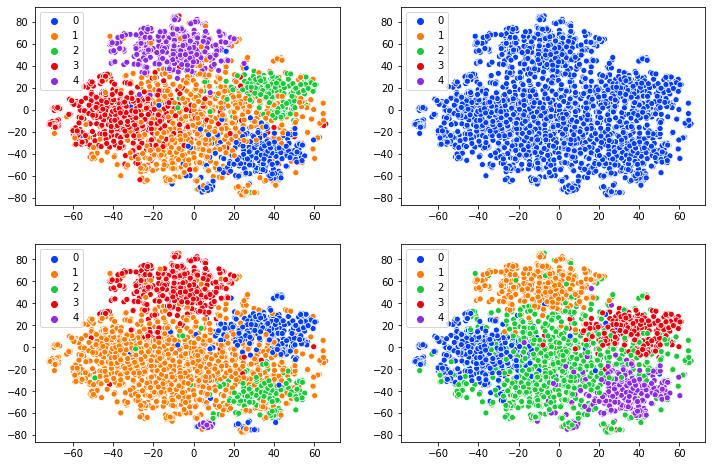

In [25]:
dbscan_labels = get_dbscan_labels(dbscan)
gmm_labels = get_gmm_labels(gmm, X_1000)
lda_labels = get_lda_labels(lda, 1000)
visualize(X_embedded=X_embedded_1000, max_features=1000, experiment=True, labels=[kmeans.labels_, dbscan_labels, agglomerative.labels_, gmm_labels])

##### Визуально выглядит конечно лучше, но все равно плохо. Нужно больше признаков :)

### Кластеризация БЕЗ GridSearchCV, max_features=2000.

In [26]:
kmeans, dbscan, agglomerative, lda, gmm = process_experiment(X_2000, max_features=2000)

0.4945526254332425
Clustering using KMeans has been processed for 34.58811712265015 seconds.
0.0
Clustering using DBSCAN has been processed for 0.44742798805236816 seconds.
0.44080366811833993
Clustering using AgglomerativeClustering has been processed for 7.326612710952759 seconds.
Clustering using LatentDirichletAllocation has been processed for 2.4818716049194336 seconds.
0.49983795851086954
Clustering using Gaussian Mixture Model has been processed for 14.534972667694092 seconds.


### Визуализация

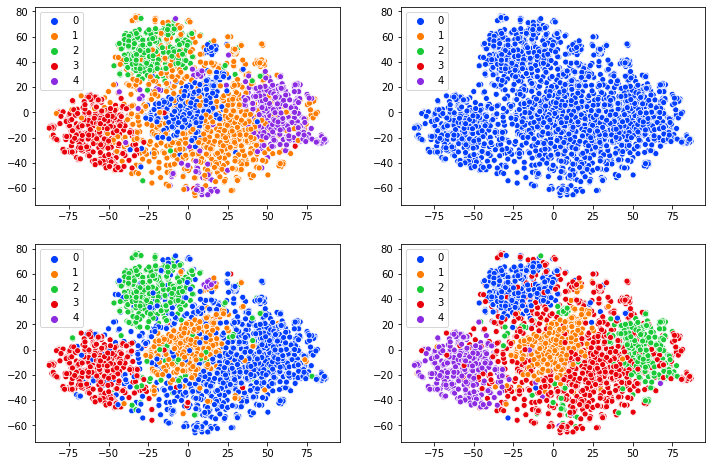

In [27]:
dbscan_labels = get_dbscan_labels(dbscan)
gmm_labels = get_gmm_labels(gmm, X_2000)
lda_labels = get_lda_labels(lda, 2000)
visualize(X_embedded=X_embedded_2000, max_features=2000, experiment=True, labels=[kmeans.labels_, dbscan_labels, agglomerative.labels_, gmm_labels])

##### Есть прирост с предыдущей попыткой, однако визуально увидеть разницу конечно непросто. Темпы роста качества с добавлением числа фичей замедлились :(

### Кластеризация БЕЗ GridSearchCV, max_features=5000.

In [28]:
kmeans, dbscan, agglomerative, lda, gmm = process_experiment(X_5000, max_features=5000)

0.5817311442899494
Clustering using KMeans has been processed for 54.52583980560303 seconds.
0.0
Clustering using DBSCAN has been processed for 0.42090272903442383 seconds.
0.41012153666468865
Clustering using AgglomerativeClustering has been processed for 18.09855818748474 seconds.
Clustering using LatentDirichletAllocation has been processed for 2.066976308822632 seconds.
0.5540121011858815
Clustering using Gaussian Mixture Model has been processed for 89.00047016143799 seconds.


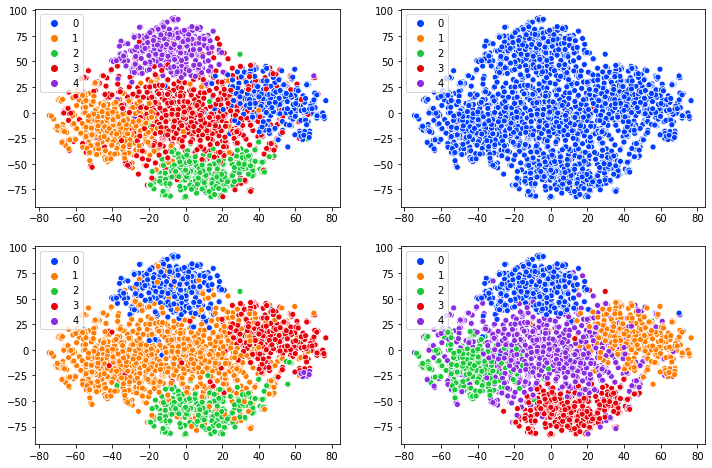

In [30]:
dbscan_labels = get_dbscan_labels(dbscan)
gmm_labels = get_gmm_labels(gmm, X_5000)
lda_labels = get_lda_labels(lda, 5000)
visualize(X_embedded=X_embedded_5000, max_features=5000, experiment=True, labels=[kmeans.labels_, dbscan_labels, agglomerative.labels_, gmm_labels])

##### Kmeans++ и GMM вырываются вперёд, аггломеративная теряет качество по сравнению с 2к фичей. Сильно возрастает время выполнения Kmeans++, GMM и Agglomerative, а также требования к вычислительным ресурсам. Особенно почувствовал это на GMM.

### Кластеризация БЕЗ GridSearchCV, max_features=10000.

In [31]:
kmeans, dbscan, agglomerative, lda, gmm = process_experiment(X_10000, max_features=10000)

0.46615954375490953
Clustering using KMeans has been processed for 39.10910415649414 seconds.
0.0
Clustering using DBSCAN has been processed for 0.4584372043609619 seconds.
0.4974202777818683
Clustering using AgglomerativeClustering has been processed for 36.06311082839966 seconds.
Clustering using LatentDirichletAllocation has been processed for 1.8563101291656494 seconds.


MemoryError: 

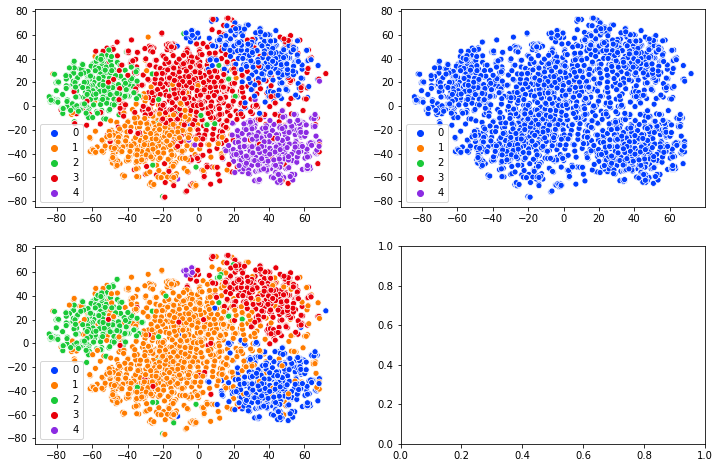

In [33]:
dbscan_labels = get_dbscan_labels(dbscan)
visualize(X_embedded=X_embedded_10000, max_features=10000, experiment=True, labels=[kmeans.labels_, dbscan_labels, agglomerative.labels_])

##### Kmeans деградирует, а Аггломеративная вырывается вперёд. GMM не получается использовать из-за вычислительных проблем, нехватка памяти. Так как аггломеративная показала рост, попробуем её и KMeans на 25k фичей.

In [34]:
X_25000 = vectorize_data('tfidf', data_train, max_features=25000)
tsne_25000 = TSNE(n_components=2)
X_embedded_25000 = tsne_10000.fit_transform(X_25000)

In [37]:
start_time = time.time()
kmeans = cluster_data('kmeans', X_25000)
print(adjusted_rand_score(labels_global, kmeans.labels_))
print(f'Clustering using KMeans has been processed for {time.time() - start_time} seconds.')

start_time = time.time()
agglomerative = cluster_data('agglomerative', X_25000.todense())
print(adjusted_rand_score(labels_global, agglomerative.labels_))
print(f'Clustering using AgglomerativeClustering has been processed for {time.time() - start_time} seconds.')

0.48021682228311485
Clustering using KMeans has been processed for 50.02123141288757 seconds.
0.4706237692719605
Clustering using AgglomerativeClustering has been processed for 90.26315975189209 seconds.


In [ ]:
visualize(X_embedded=X_embedded_25000, max_features=25000, experiment=True, labels=[kmeans.labels_, agglomerative.labels_])

##### Ни Kmeans, ни Agglomerative это никак не помогает, только обучение все больше и больше времени занимает. Таким образом, выбор сделан в пользу проведения экспериментов над моделями Kmeans(5k features), Agglomerative(10k features), GMM(5k features).

### Попробуем добавить стемминг и лемматизацию при векторизации коллекции.

In [38]:
start_time = time.time()

X_5000_stemmed = vectorize_data('tfidf', data_train, max_features=5000, stemming=True)
X_10000_stemmed = vectorize_data('tfidf', data_train, max_features=10000, stemming=True)
X_5000_lemmatized = vectorize_data('tfidf', data_train, max_features=5000, lemmatization=True)
X_10000_lemmatized = vectorize_data('tfidf', data_train, max_features=10000, lemmatization=True)
tsne_5000_stemmed = TSNE(n_components=2)
tsne_10000_stemmed = TSNE(n_components=2)
tsne_5000_lemmatized = TSNE(n_components=2)
tsne_10000_lemmatized = TSNE(n_components=2)
X_embedded_5000_stemmed = tsne_5000_stemmed.fit_transform(X_5000_stemmed)
X_embedded_10000_stemmed = tsne_10000_stemmed.fit_transform(X_10000_stemmed)
X_embedded_5000_lemmatized = tsne_5000_lemmatized.fit_transform(X_5000_lemmatized)
X_embedded_10000_lemmatized = tsne_10000_lemmatized.fit_transform(X_10000_lemmatized)

print(f'Processed for {time.time() - start_time} seconds.')

Processed for 109.13280177116394 seconds.


In [40]:
start_time = time.time()
kmeans = cluster_data('kmeans', X_5000_stemmed)
print(adjusted_rand_score(labels_global, kmeans.labels_))
print(f'Clustering using KMeans has been processed for {time.time() - start_time} seconds.')

start_time = time.time()
agglomerative = cluster_data('agglomerative', X_10000_stemmed.todense())
print(adjusted_rand_score(labels_global, agglomerative.labels_))
print(f'Clustering using AgglomerativeClustering has been processed for {time.time() - start_time} seconds.')

start_time = time.time()
gmm = cluster_data('gmm', X_5000_stemmed.todense())
print(adjusted_rand_score(labels_global, gmm.predict(X_5000_stemmed.todense())))
print(f'Clustering using Gaussian Mixture Model has been processed for {time.time() - start_time} seconds.')

0.5218160865168454
Clustering using KMeans has been processed for 47.881468534469604 seconds.
0.3261124478389112
Clustering using AgglomerativeClustering has been processed for 36.745211124420166 seconds.
0.40525906430788616
Clustering using Gaussian Mixture Model has been processed for 93.53268551826477 seconds.


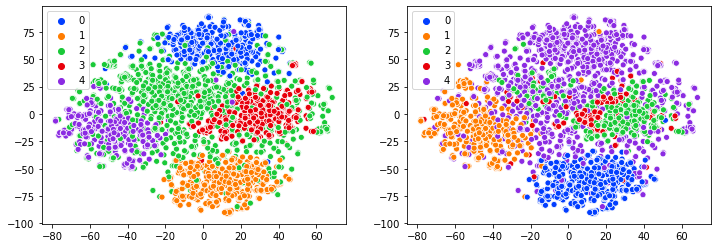

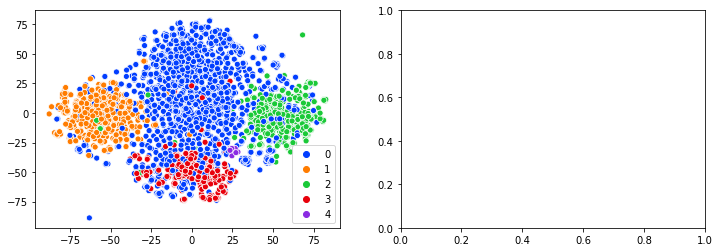

In [41]:
gmm_labels = get_gmm_labels(gmm, X_5000_stemmed)
visualize(X_embedded=X_embedded_5000_stemmed, max_features=5000, experiment=True, labels=[kmeans.labels_, gmm_labels])
visualize(X_embedded=X_embedded_10000_stemmed, max_features=10000, experiment=True, labels=[agglomerative.labels_])

##### Добавление стемминга не оправдало моих ожиданий - имеет место деградация качества! Хотя Kmeans неплох. Интересно, что при меньшем числе фичей (2k) стемминг немного улучшал качество. 

In [42]:
start_time = time.time()
kmeans = cluster_data('kmeans', X_5000_lemmatized)
print(adjusted_rand_score(labels_global, kmeans.labels_))
print(f'Clustering using KMeans has been processed for {time.time() - start_time} seconds.')

start_time = time.time()
agglomerative = cluster_data('agglomerative', X_10000_lemmatized.todense())
print(adjusted_rand_score(labels_global, agglomerative.labels_))
print(f'Clustering using AgglomerativeClustering has been processed for {time.time() - start_time} seconds.')

start_time = time.time()
gmm = cluster_data('gmm', X_5000_lemmatized.todense())
print(adjusted_rand_score(labels_global, gmm.predict(X_5000_lemmatized.todense())))
print(f'Clustering using Gaussian Mixture Model has been processed for {time.time() - start_time} seconds.')

0.5151625469573182
Clustering using KMeans has been processed for 46.777740478515625 seconds.
0.5080899086332187
Clustering using AgglomerativeClustering has been processed for 36.48316311836243 seconds.
0.3791164150439543
Clustering using Gaussian Mixture Model has been processed for 87.19257354736328 seconds.


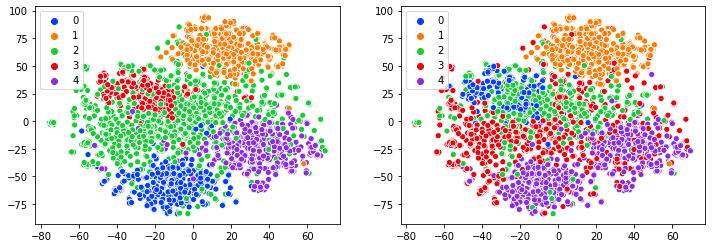

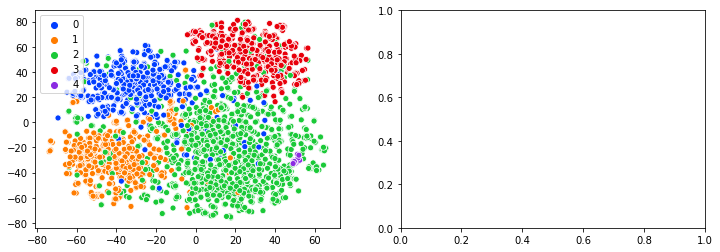

In [43]:
gmm_labels = get_gmm_labels(gmm, X_5000_lemmatized)
visualize(X_embedded=X_embedded_5000_lemmatized, max_features=5000, experiment=True, labels=[kmeans.labels_, gmm_labels])
visualize(X_embedded=X_embedded_10000_lemmatized, max_features=10000, experiment=True, labels=[agglomerative.labels_])

##### Kmeans и Agglomerative хорошо восприняли лемматизацию, а вот GMM она явно здесь ни к чему. Визуально конечно красиво, но слишком много различий с ground-truth.

## Попробуем оценить влияние кросс-валидации на качество.

### Кластеризация С GridSearchCV, max_features=5000. 2-fold Кросс-валидация.

In [49]:
kmeans, dbscan, agglomerative, lda, gmm = process_experiment(X_5000, max_features=5000, grid_search=True, cv=2)

{'n_clusters': 5}
0.6551594885988329
Clustering using KMeans has been processed for 169.24836826324463 seconds.
0.0
Clustering using DBSCAN has been processed for 0.4469270706176758 seconds.
0.41012153666468865
Clustering using AgglomerativeClustering has been processed for 18.211264610290527 seconds.
{'n_components': 5}
Clustering using LatentDirichletAllocation has been processed for 24.527913093566895 seconds.
{'n_components': 5}
0.5152370101905079
Clustering using Gaussian Mixture Model has been processed for 624.300351858139 seconds.


### Визуализация

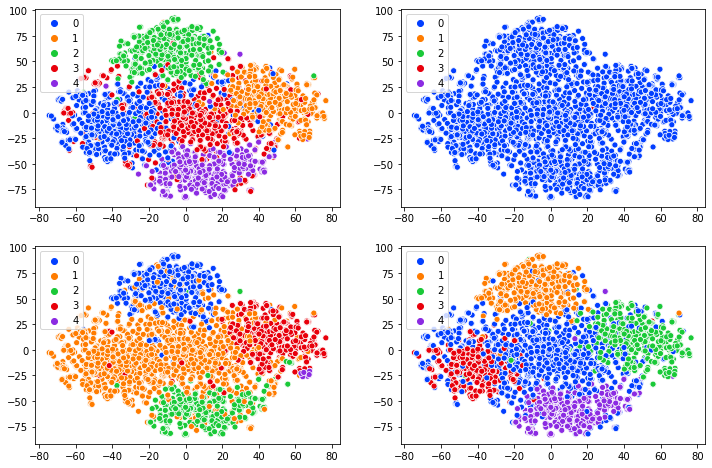

In [50]:
dbscan_labels = get_dbscan_labels(dbscan)
gmm_labels = get_gmm_labels(gmm, X_5000)
lda_labels = get_lda_labels(lda, 5000)
visualize(X_embedded=X_embedded_5000, max_features=5000, experiment=True, labels=[kmeans.labels_, dbscan_labels, agglomerative.labels_, gmm_labels])

### Кластеризация С GridSearchCV, max_features=5000. 5-fold Кросс-валидация.

In [ ]:
kmeans, dbscan, agglomerative, lda, gmm = process_experiment(X_5000, max_features=5000, grid_search=True)

### Визуализация

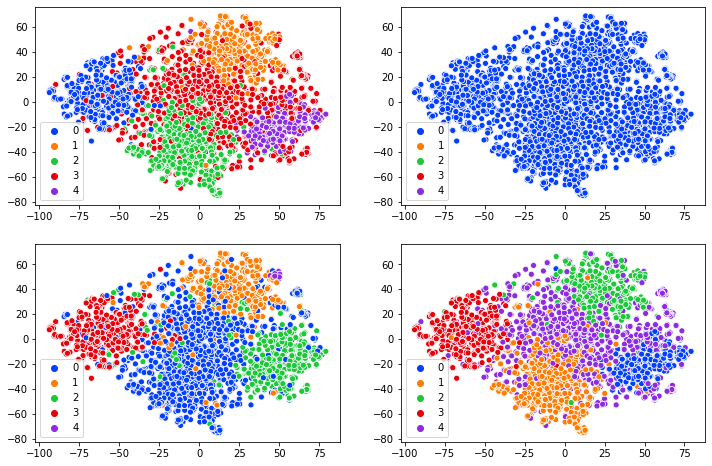

In [179]:
dbscan_labels = get_dbscan_labels(dbscan)
gmm_labels = get_gmm_labels(gmm, X_5000)
lda_labels = get_lda_labels(lda, 5000)
visualize(X_embedded=X_embedded_5000, max_features=5000, experiment=True, labels=[kmeans.labels_, dbscan_labels, agglomerative.labels_, gmm_labels])

## Summary:

##### Все полученные без кросс-валидации оценки качества глобально считаю неудовлетворительными, локально же очень хорошо себя показали Kmeans++ и GMM без лемматизации или стемминга.

##### Изменение числа извлекаемых фичей при векторизации оказывает огромное влияние на качество. Сначала до какого-то момента оно растёт, однако затем начинает падать, так что не нужно бездумно извлекать 100k фичей.

##### Кросс-валидация - это вам не шутки! 2-fold CV Даёт большой скачок в качестве для Kmeans++, так что для него must-use, иначе говоря. Такую оценку я бы уже назвал удовлетворительной, пусть и с натяжкой (все-таки 5 категорий, 2 из которых сильно пересекаются, а из-за нехватки вычислительных ресурсов нет возможности воспользоваться оптимизацией гиперпараметров на полную). Остальным алгоритмам 2-fold кросс-валидация не дала